In [1]:
pip install shap lime lazypredict

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import lime
import lime.lime_tabular
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/loan_approval_dataset.csv')
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [5]:
df.shape

(4269, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [7]:
df.drop('loan_id', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score               4269 non-null   int64 
 7   residential_assets_value  4269 non-null   int64 
 8   commercial_assets_value   4269 non-null   int64 
 9   luxury_assets_value       4269 non-null   int64 
 10  bank_asset_value          4269 non-null   int64 
 11  loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 400.3+ KB


In [8]:
df.isnull().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

In [9]:
df.duplicated().sum()

0

## Exploratory Data Analysis

In [10]:
cat_variables = ['no_of_dependents', 'education', 'self_employed', 'loan_status']
num_variables = ['income_annum', 'loan_amount', 'loan_term', 'cibil_score',
                 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value',
                 'bank_asset_value']

In [11]:
for col in cat_variables:
    value_counts = df[col].value_counts()
    print(f"Column: {col}")
    print(value_counts)
    print("-----------------------")

Column: no_of_dependents
4    752
3    727
0    712
2    708
1    697
5    673
Name: no_of_dependents, dtype: int64
-----------------------
Column: education
Graduate        2144
Not Graduate    2125
Name: education, dtype: int64
-----------------------
Column: self_employed
Yes    2150
No     2119
Name: self_employed, dtype: int64
-----------------------
Column: loan_status
Approved    2656
Rejected    1613
Name: loan_status, dtype: int64
-----------------------


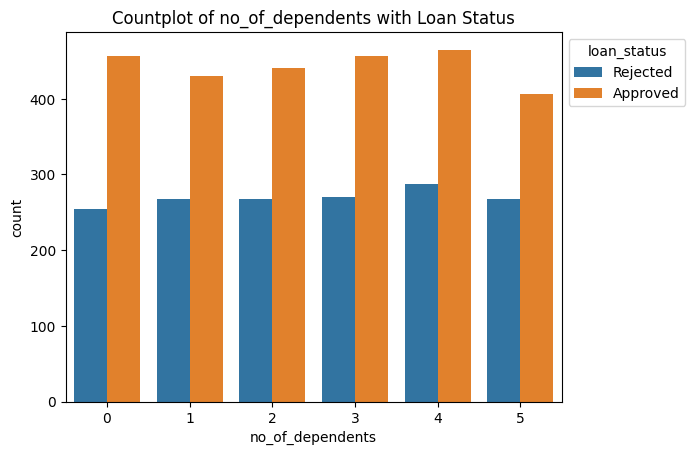

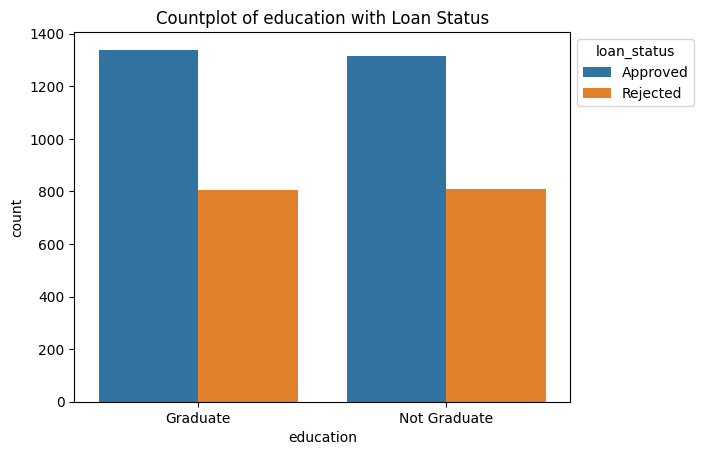

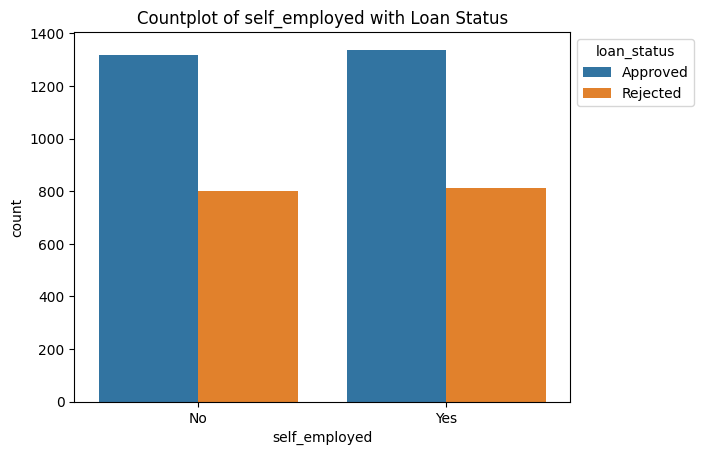

In [12]:
for column in cat_variables:
    if column != 'loan_status':
        ax = sns.countplot(data=df, x=column, hue='loan_status')
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.title(f'Countplot of {column} with Loan Status')
        plt.show()

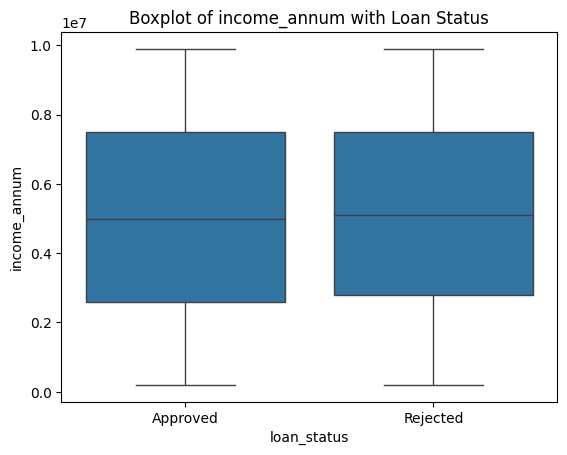

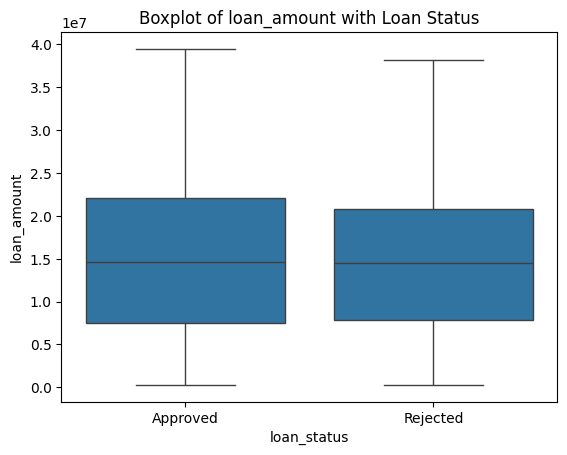

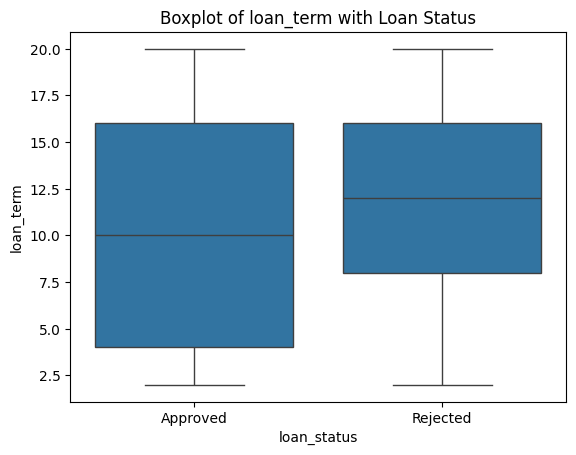

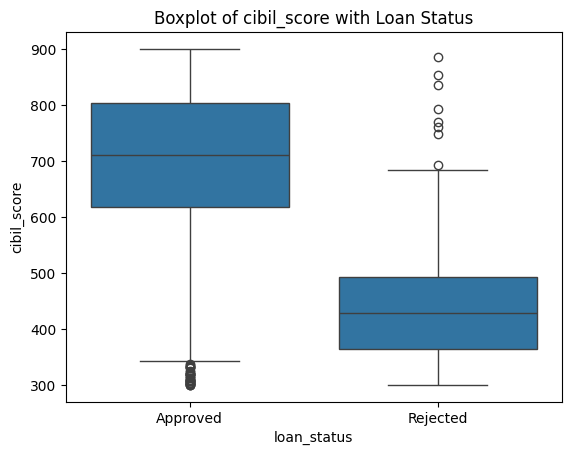

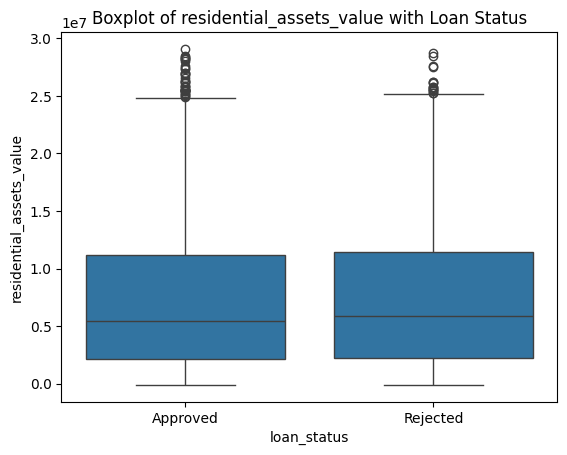

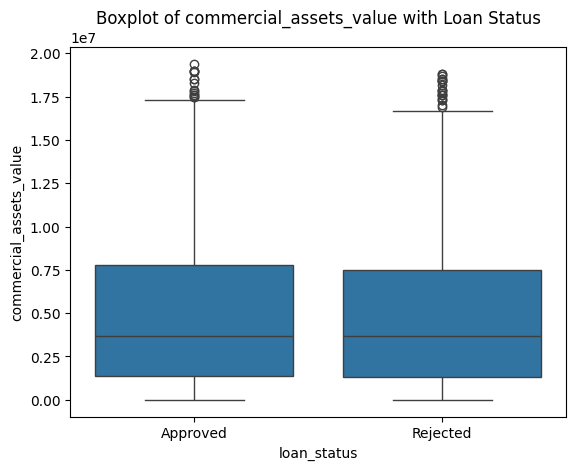

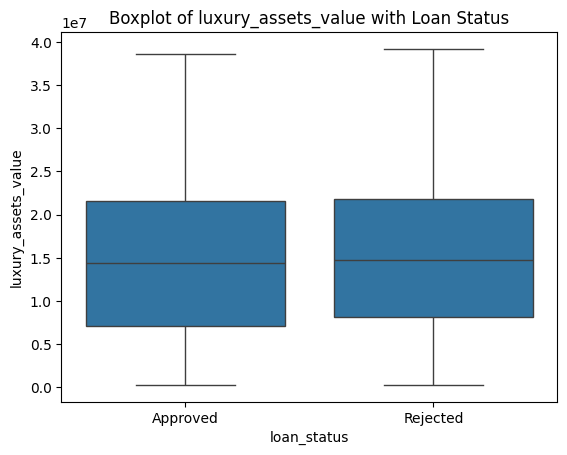

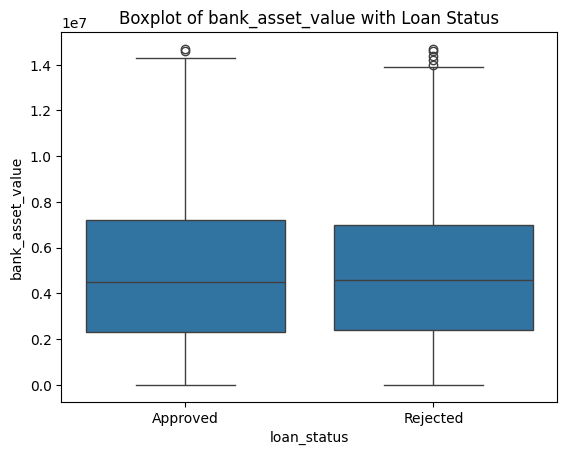

In [13]:
for column in num_variables:
    sns.boxplot(data=df, y=column, x='loan_status')
    plt.title(f'Boxplot of {column} with Loan Status')
    plt.show()

## Model Training

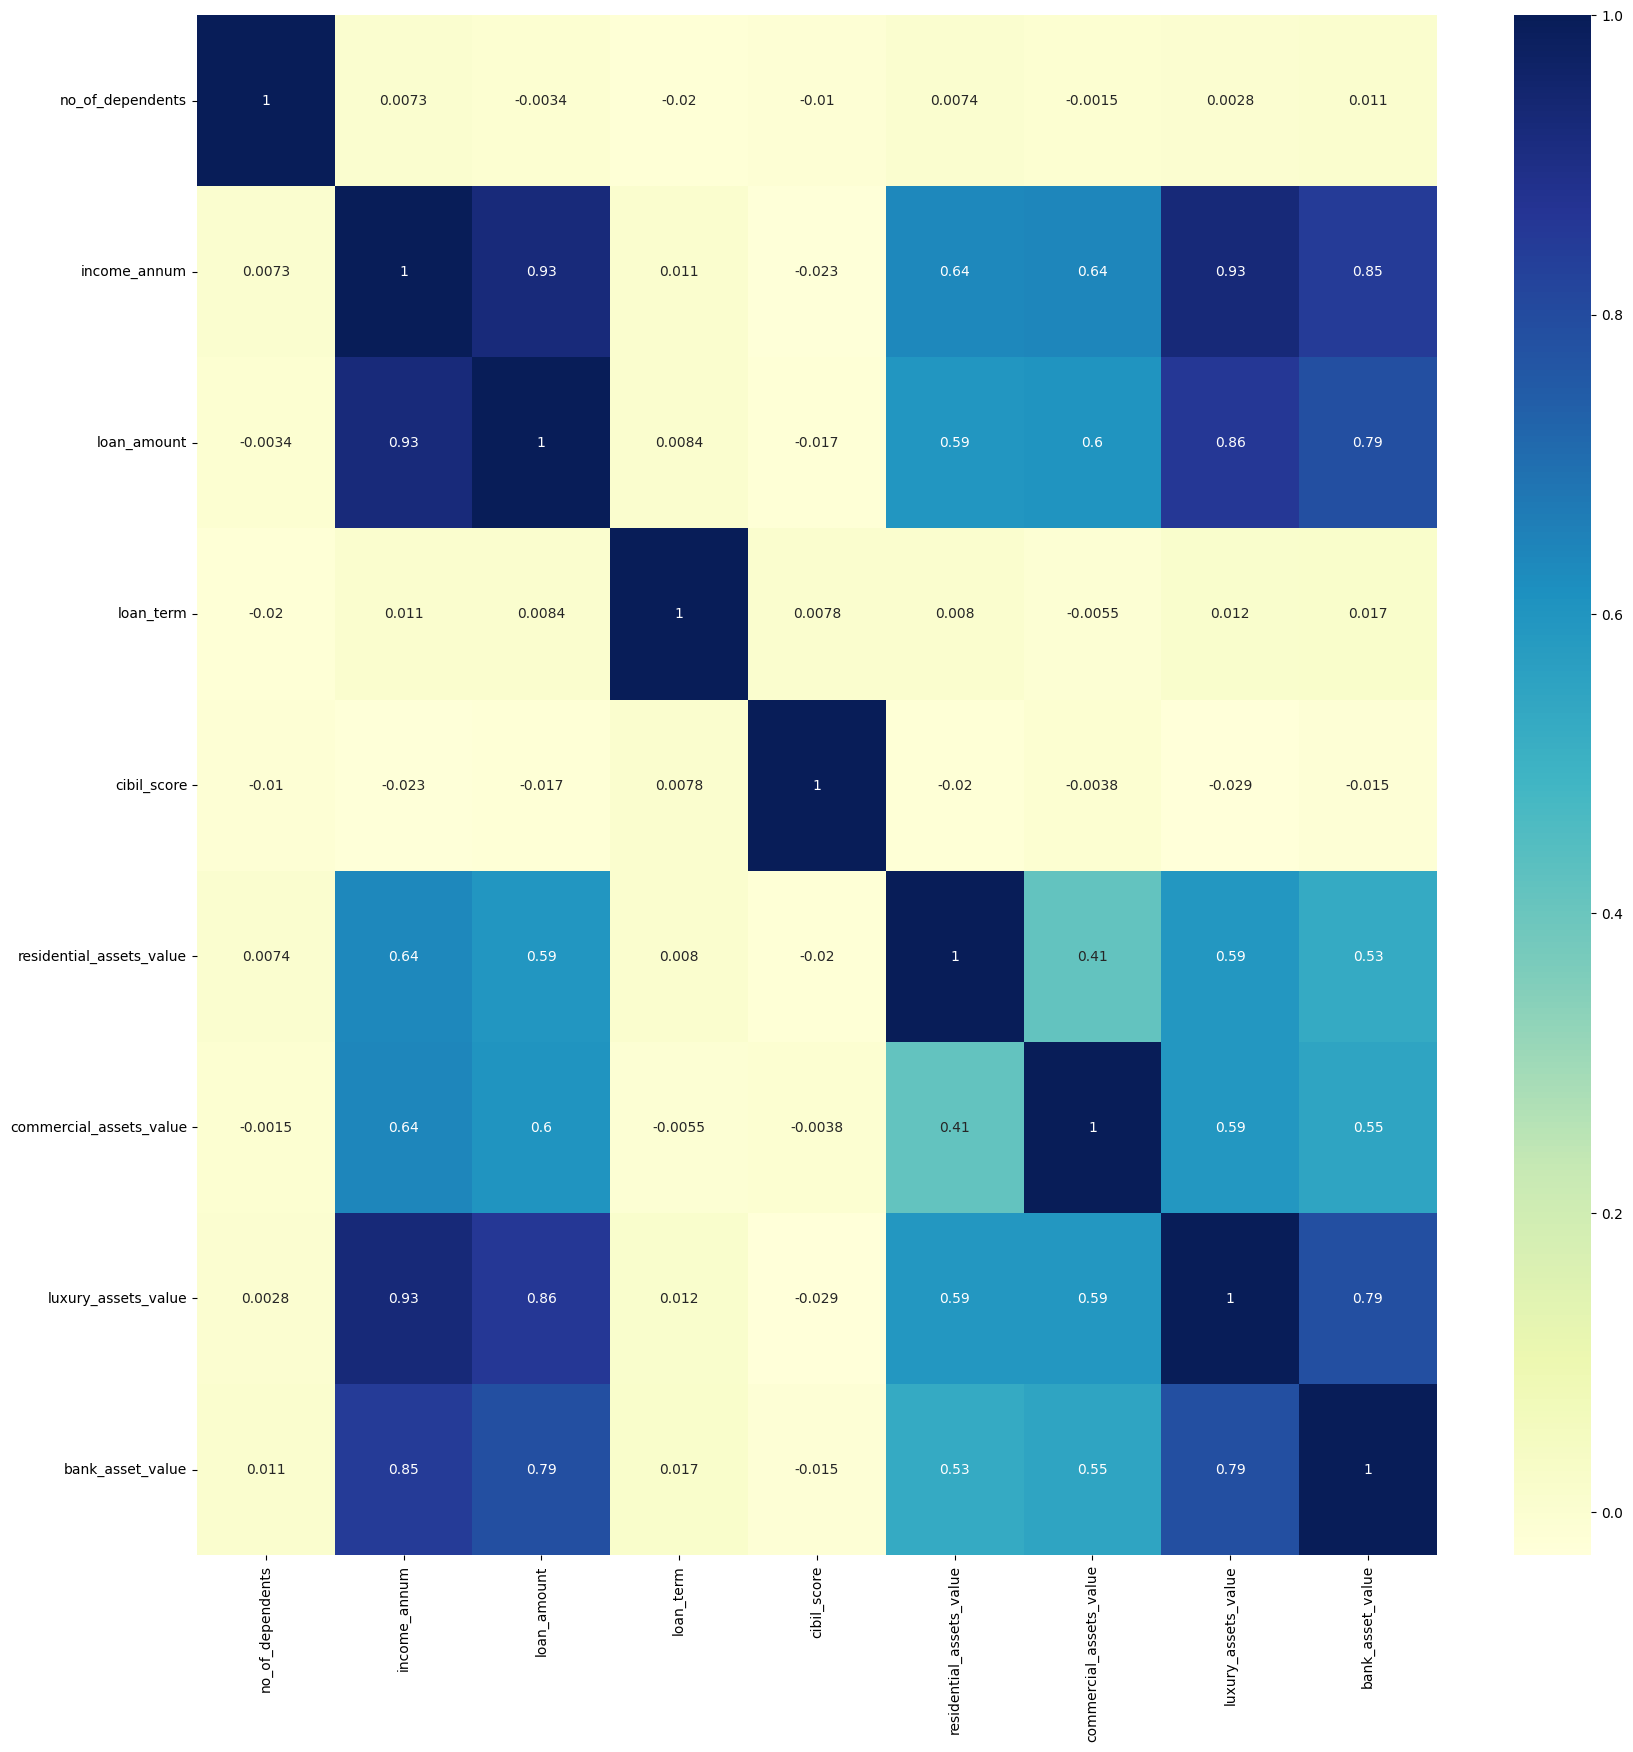

In [14]:
plt.figure(figsize= (20,20))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True)
plt.show()

In [15]:
# Dropping bcoz of high correlation with income
# Changing loan amount & annual income
df['debt_income_ratio'] = df['loan_amount']/df['income_annum']
df.drop(['luxury_assets_value', 'bank_asset_value', 'loan_amount', 'income_annum'], axis=1, inplace=True)

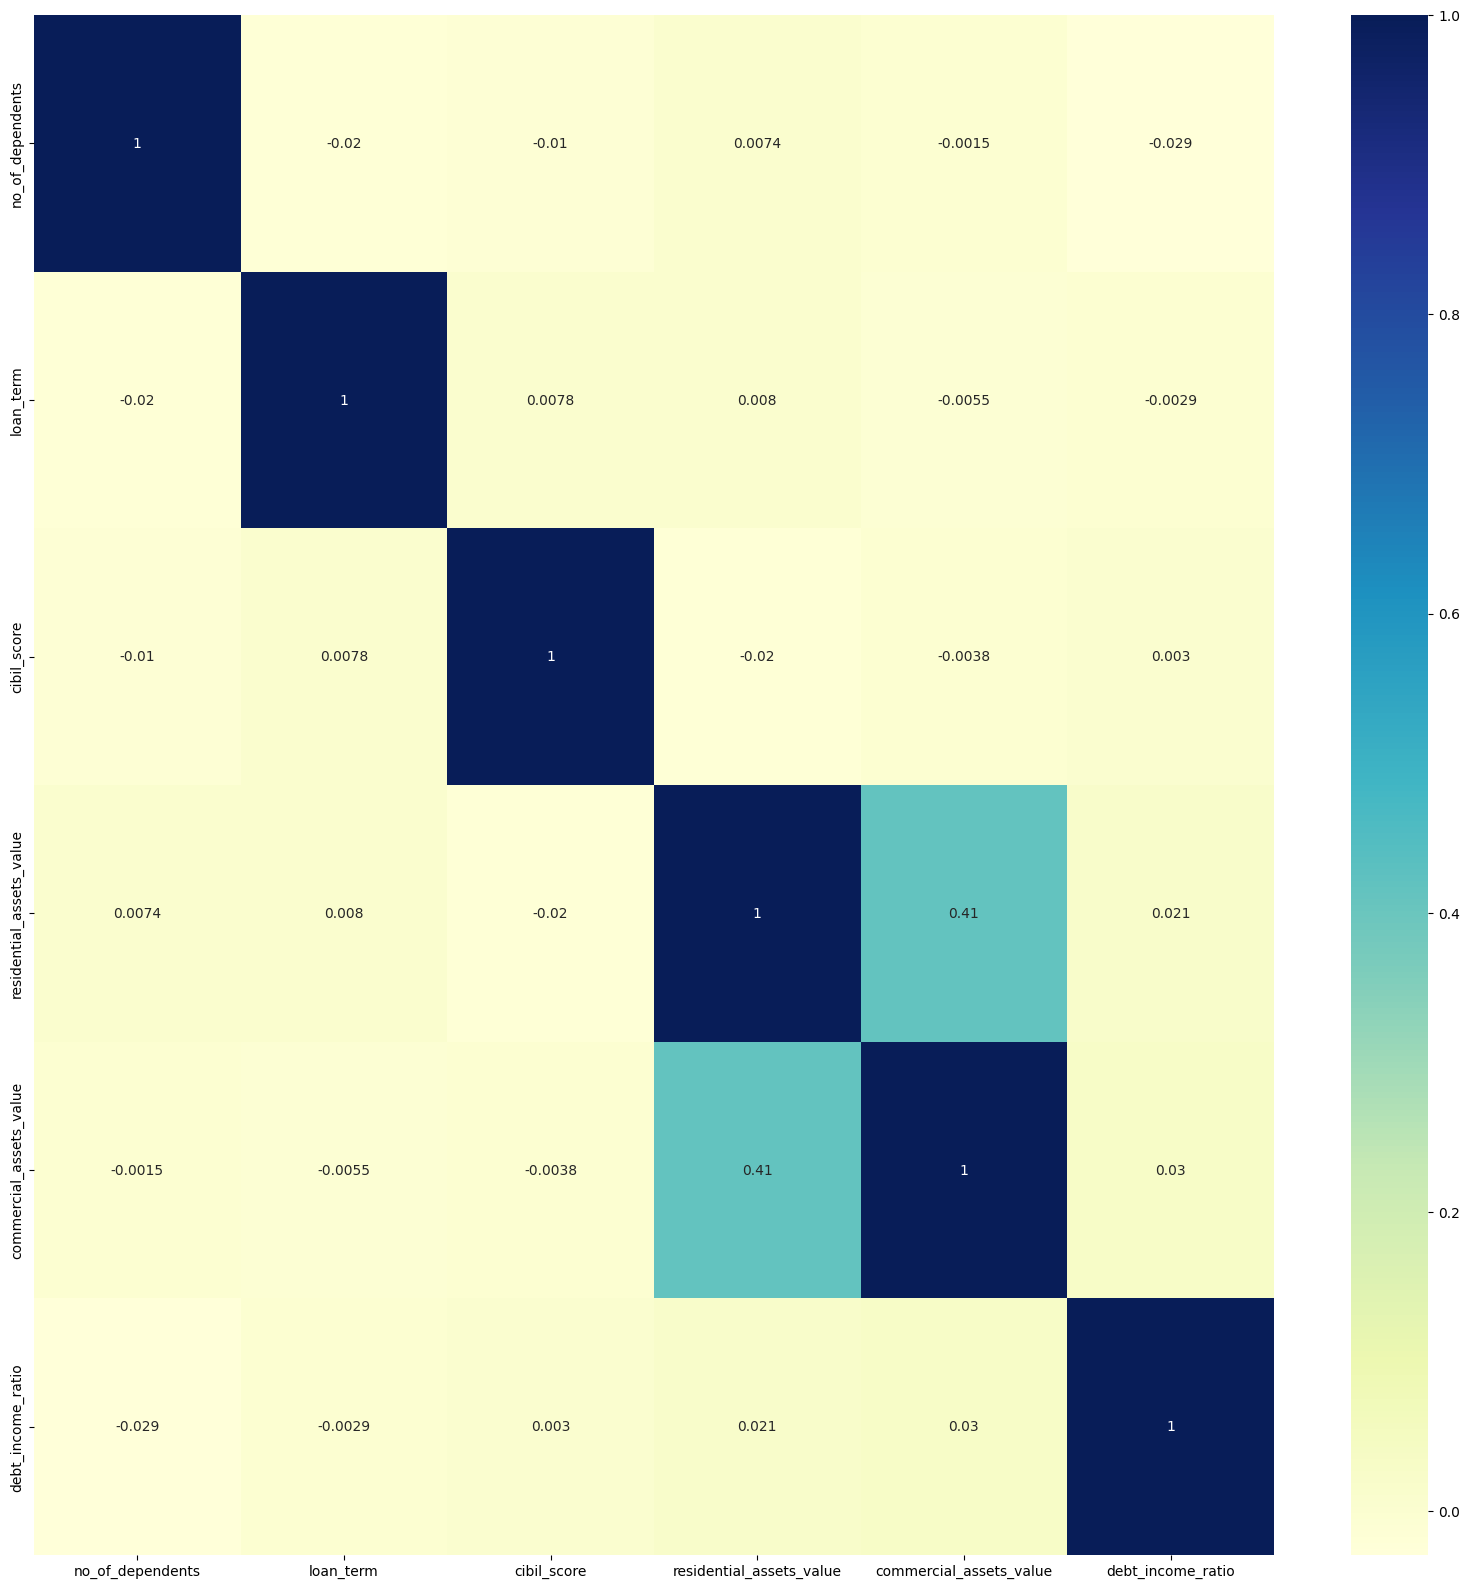

In [16]:
plt.figure(figsize= (20,20))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True)
plt.show()

In [17]:
num_variables.remove('luxury_assets_value')
num_variables.remove('bank_asset_value')
num_variables.remove('income_annum')
num_variables.remove('loan_amount')
num_variables.insert(0, 'debt_income_ratio')

num_variables

['debt_income_ratio',
 'loan_term',
 'cibil_score',
 'residential_assets_value',
 'commercial_assets_value']

In [18]:
# Converting columns
df['education'] = (df['education'] == 'Graduate').astype(int)
df['self_employed'] = (df['self_employed'] == 'Yes').astype(int)
df['loan_status'] = (df['loan_status'] == 'Approved').astype(int)

df.head()

,no_of_dependents,education,self_employed,loan_term,cibil_score,residential_assets_value,commercial_assets_value,loan_status,debt_income_ratio
0,2,1,0,12,778,2400000,17600000,1,3.11
1,0,0,1,8,417,2700000,2200000,0,2.98
2,3,1,0,20,506,7100000,4500000,0,3.26
3,3,1,0,8,467,18200000,3300000,0,3.74
4,5,0,1,20,382,12400000,8200000,0,2.47


In [19]:
# Changing column order
last_column = df.columns[-1]
df = df[[last_column] + [col for col in df if col != last_column]]

df.head()

,debt_income_ratio,no_of_dependents,education,self_employed,loan_term,cibil_score,residential_assets_value,commercial_assets_value,loan_status
0,3.11,2,1,0,12,778,2400000,17600000,1
1,2.98,0,0,1,8,417,2700000,2200000,0
2,3.26,3,1,0,20,506,7100000,4500000,0
3,3.74,3,1,0,8,467,18200000,3300000,0
4,2.47,5,0,1,20,382,12400000,8200000,0


In [20]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

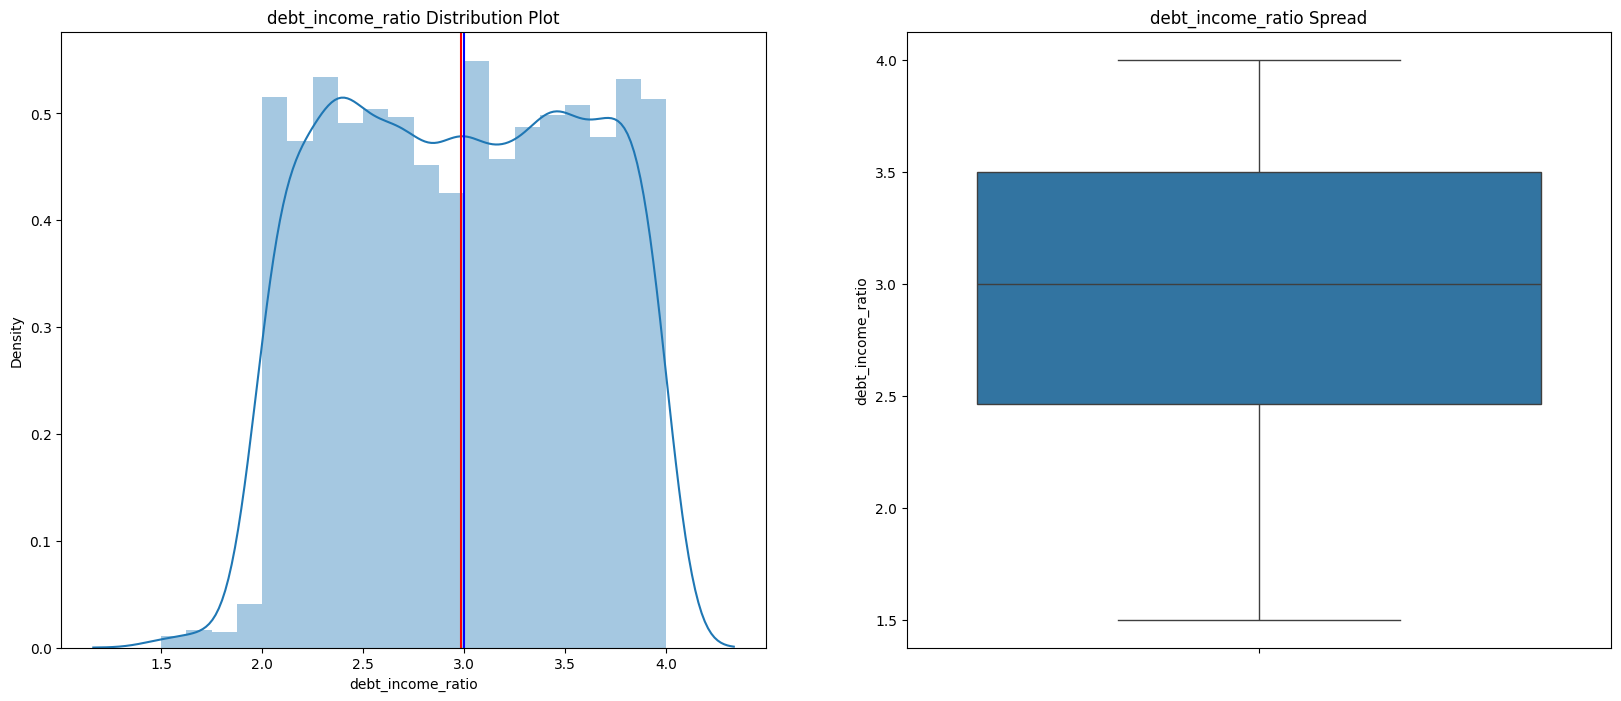

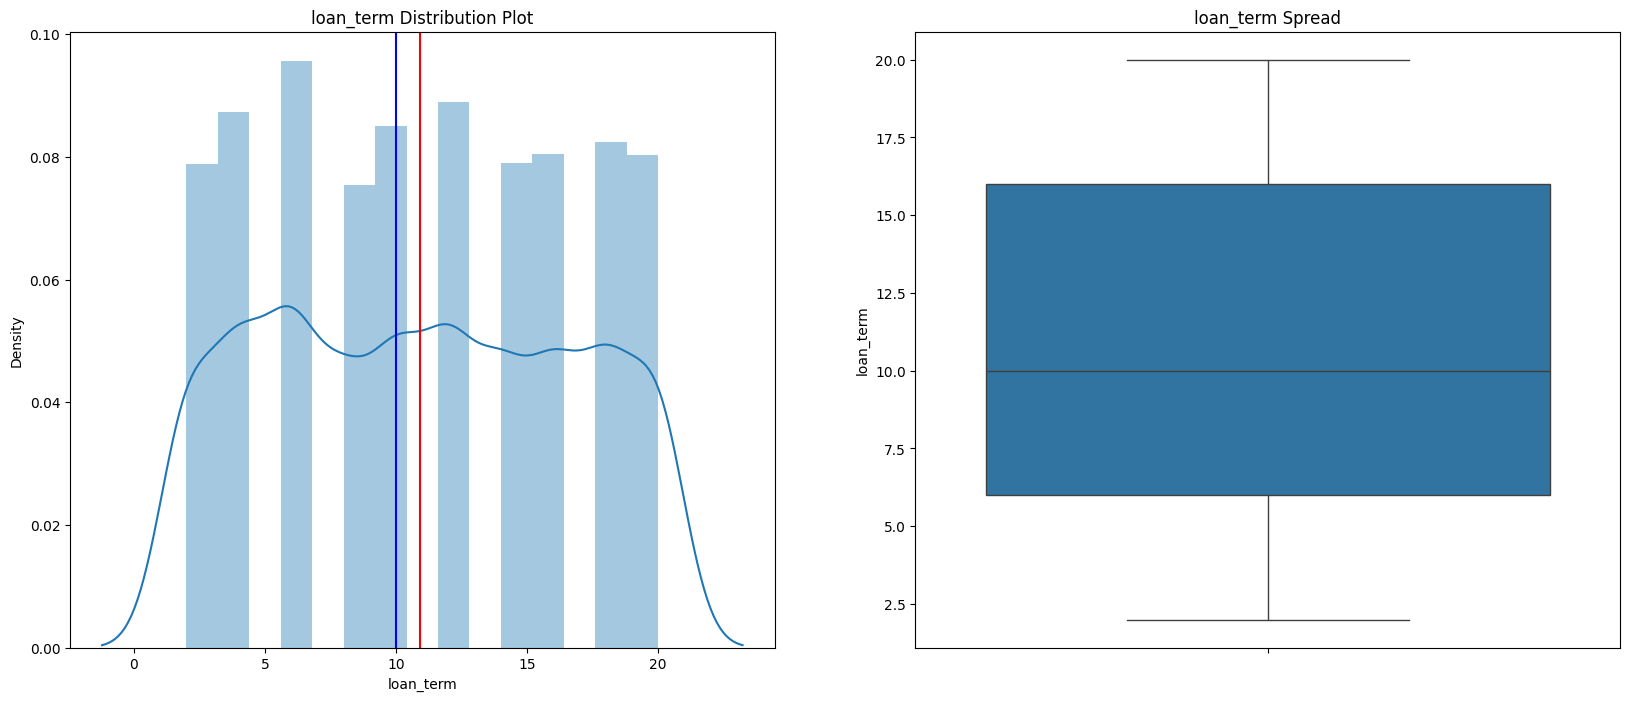

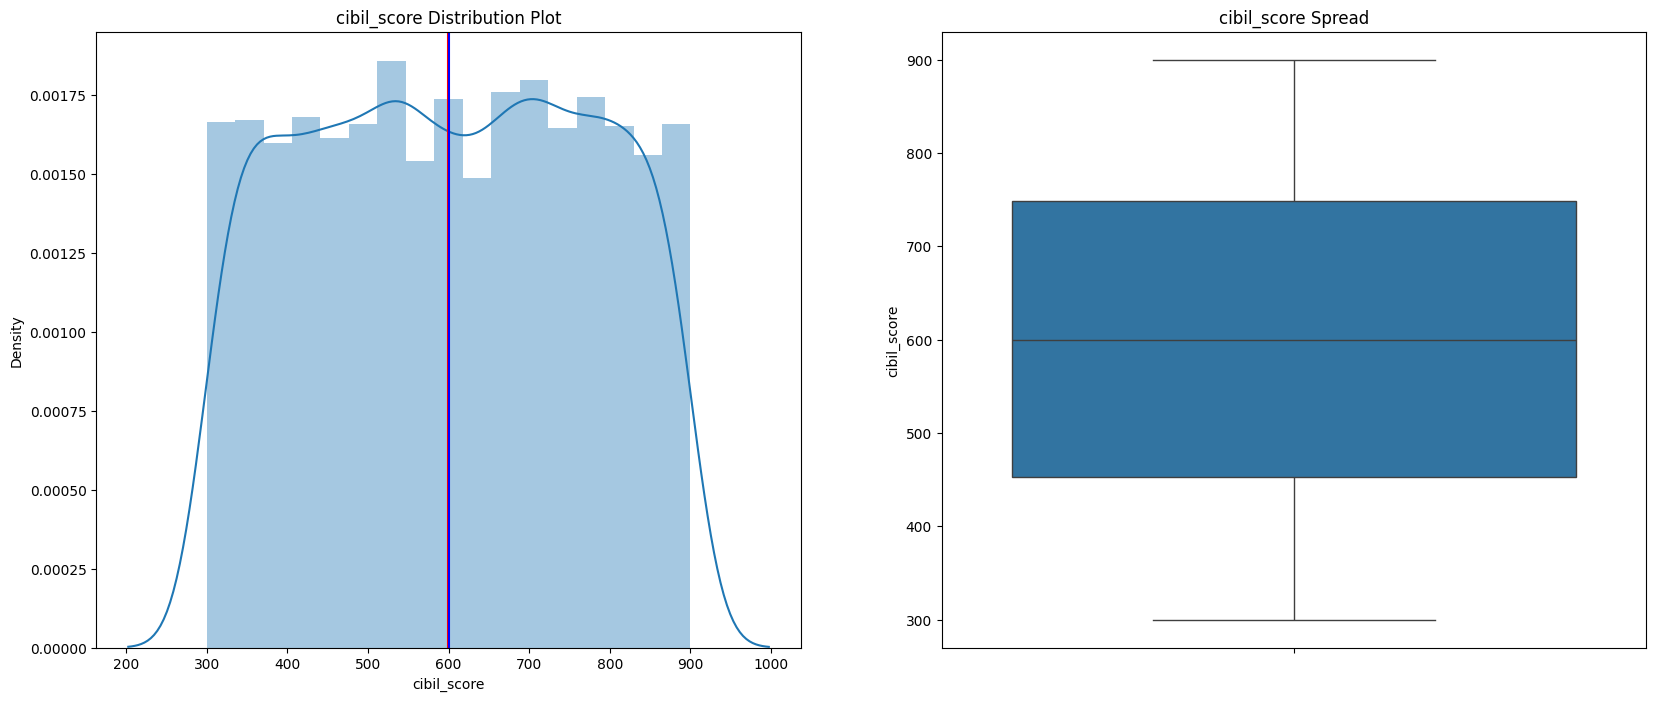

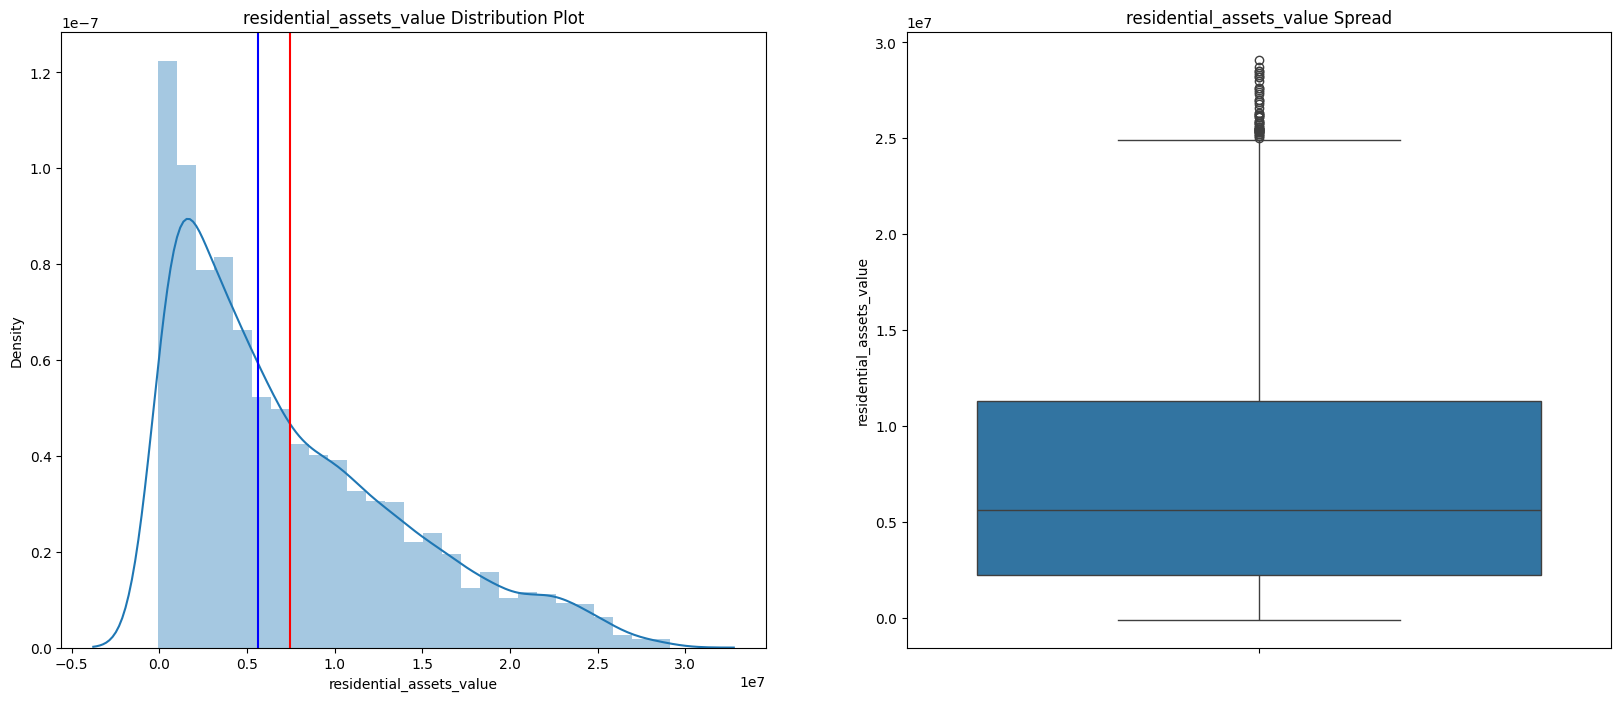

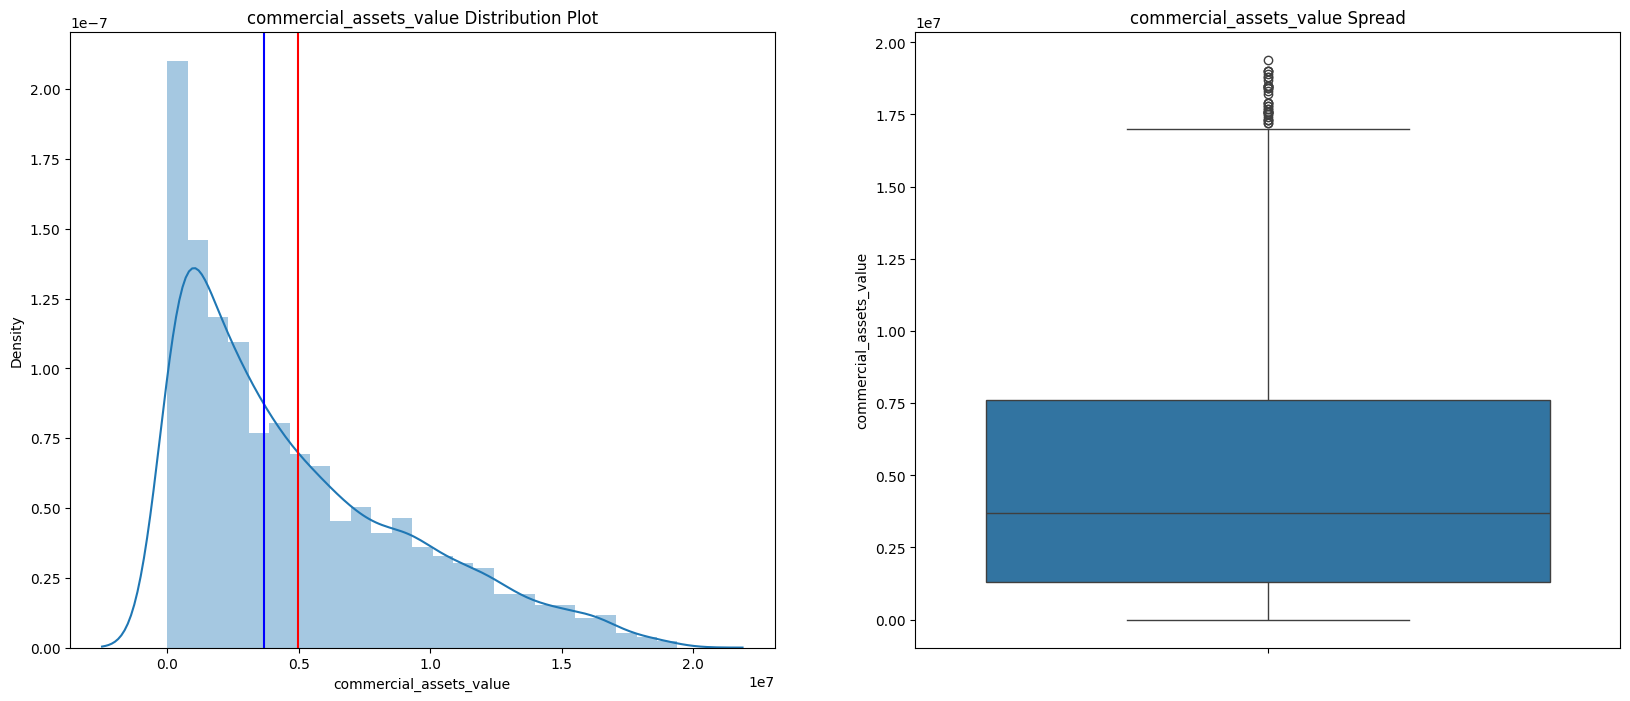

In [21]:
for column in num_variables:
    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)
    plt.title(f'{column} Distribution Plot')
    sns.distplot(X[column])
    plt.axvline(X[column].mean(), color="r")
    plt.axvline(X[column].median(), color="b")

    plt.subplot(1,2,2)
    plt.title(f'{column} Spread')
    sns.boxplot(y=X[column])

    plt.show()

In [22]:
skew_variables = ['residential_assets_value', 'commercial_assets_value']

for column in skew_variables:
    X[column] = np.cbrt((X[column]))

scaler = MinMaxScaler()
data = scaler.fit_transform(X)
X = pd.DataFrame(data, columns=X.columns)
X.head()

# Saving scaler for future use
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

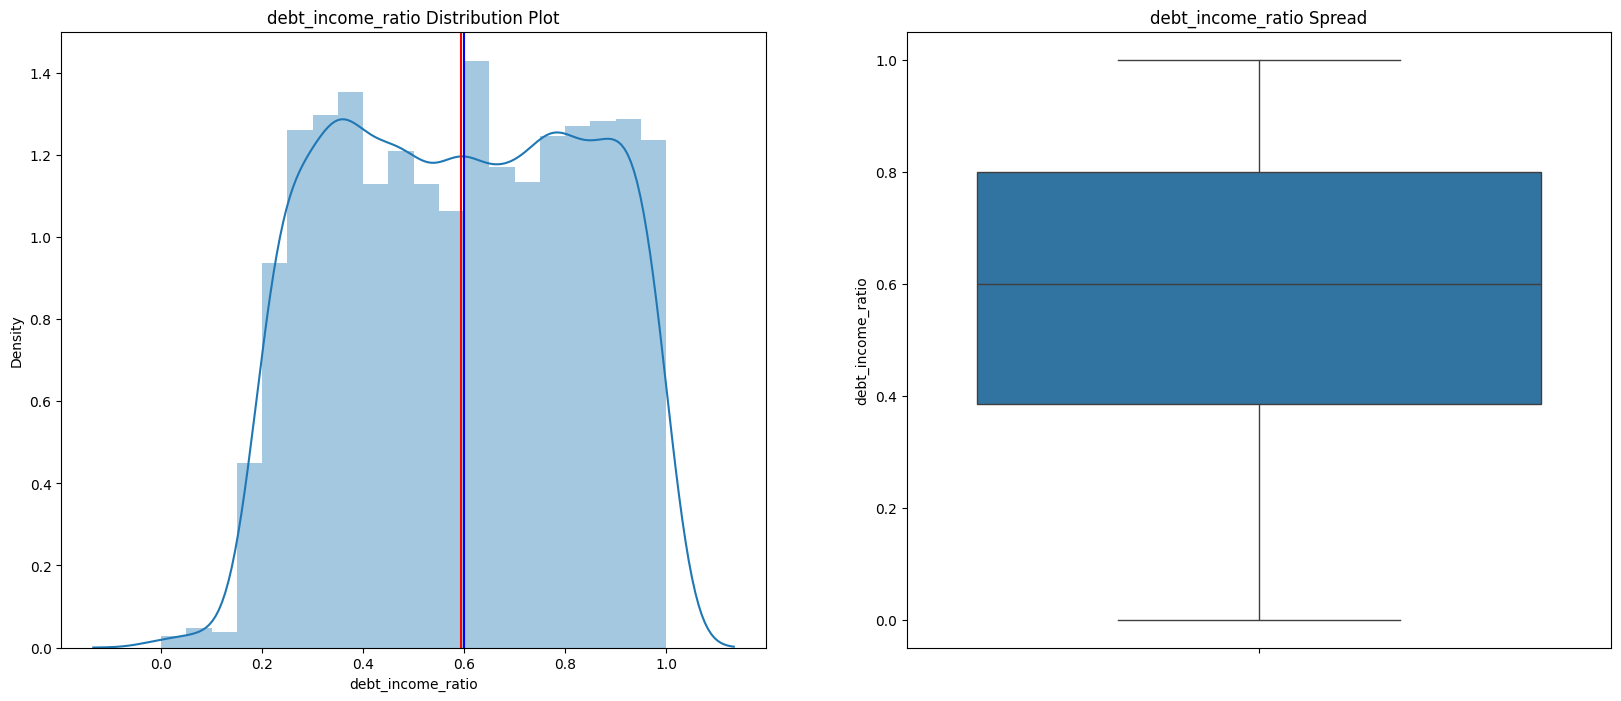

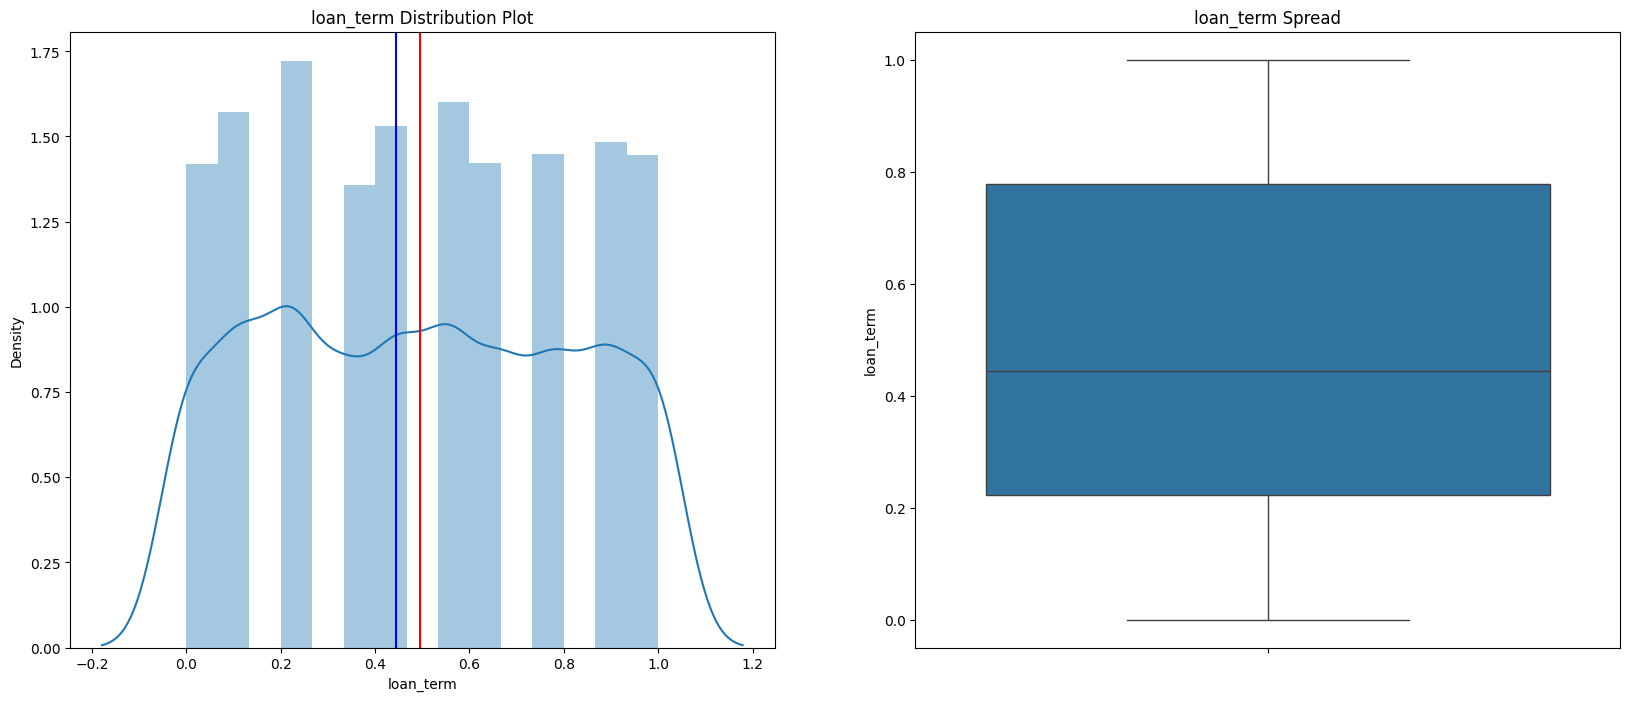

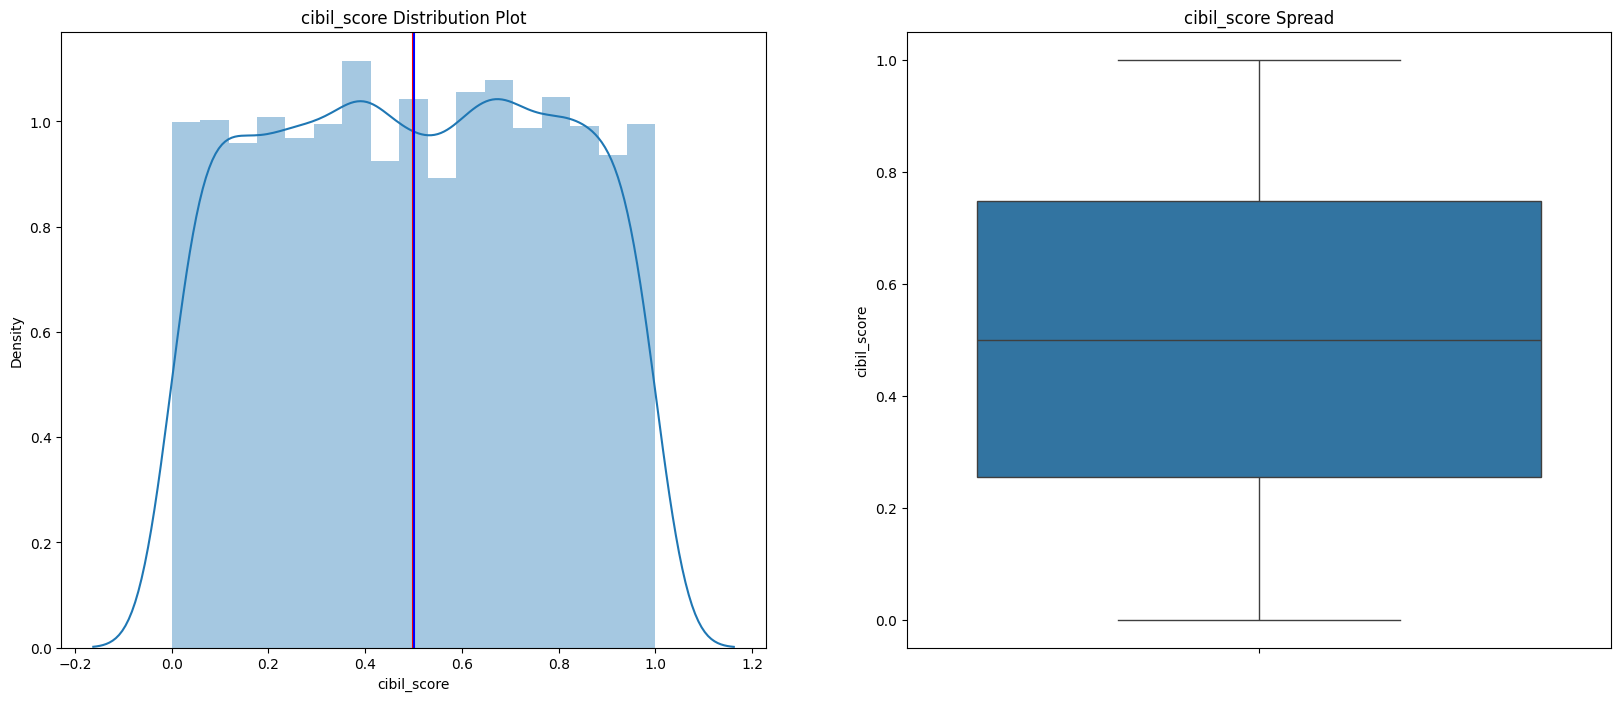

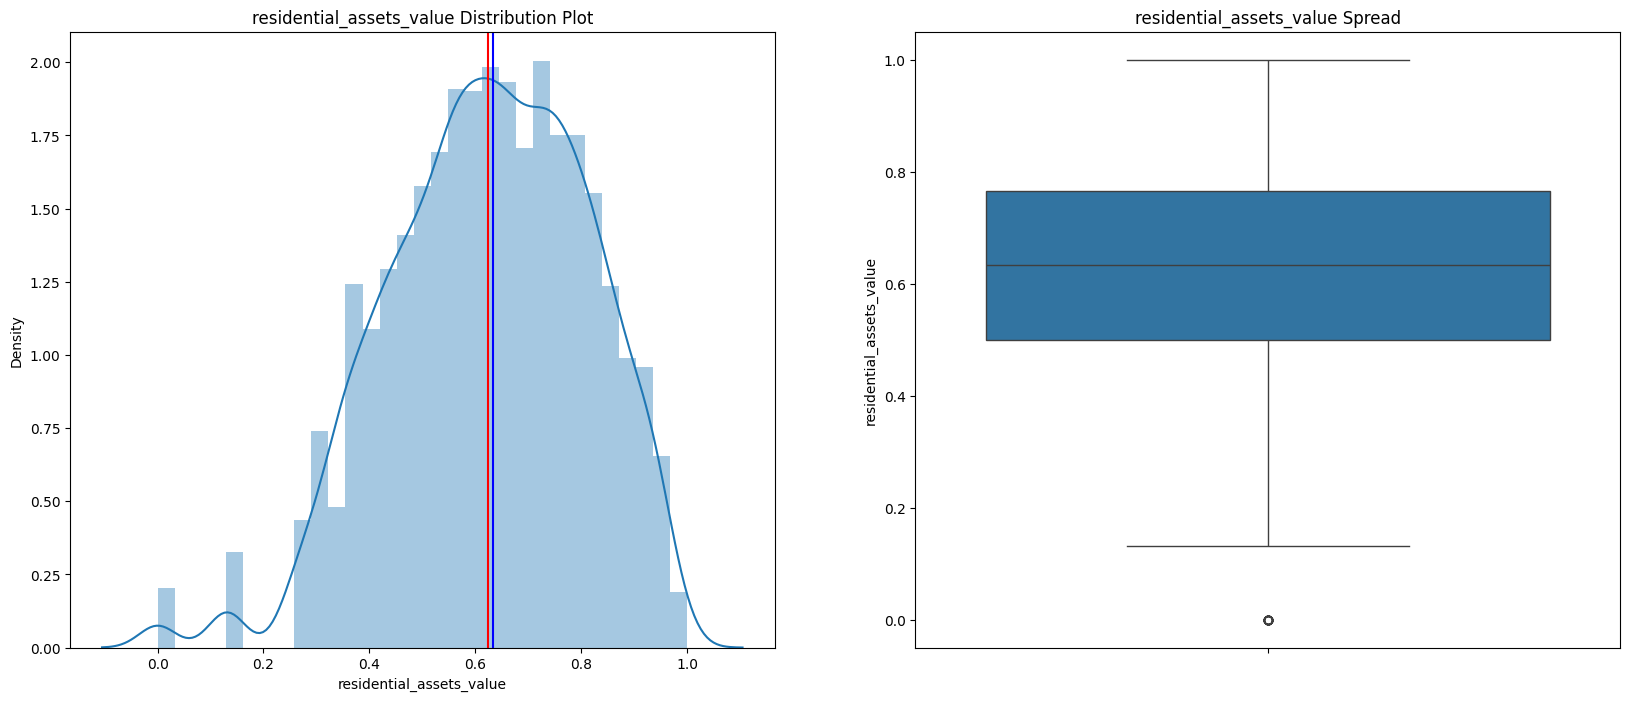

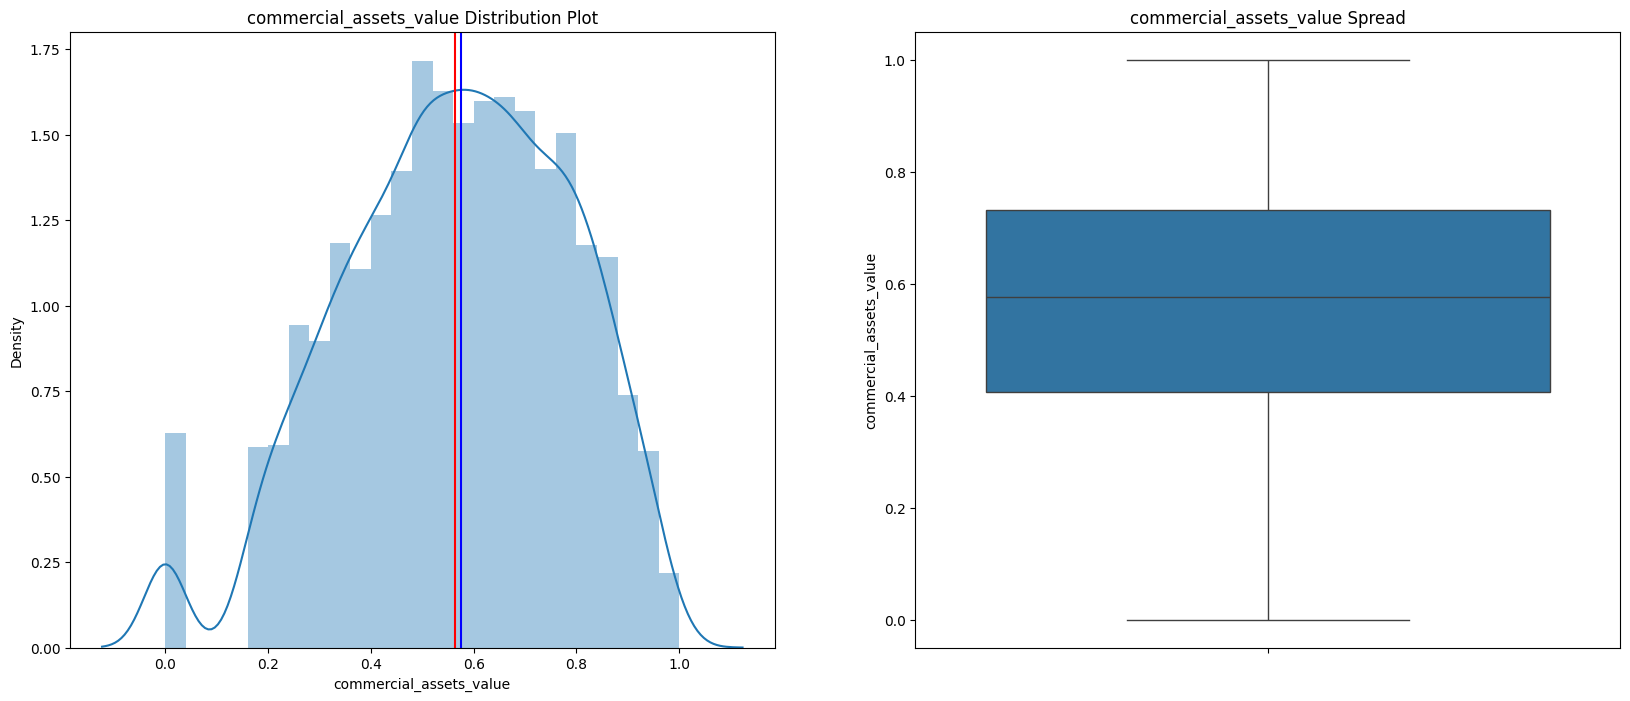

In [23]:
for column in num_variables:
    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)
    plt.title(f'{column} Distribution Plot')
    sns.distplot(X[column])
    plt.axvline(X[column].mean(), color="r")
    plt.axvline(X[column].median(), color="b")

    plt.subplot(1,2,2)
    plt.title(f'{column} Spread')
    sns.boxplot(y=X[column])

    plt.show()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [25]:
X_train.shape, X_test.shape

((3201, 8), (1068, 8))

In [26]:
y_train.shape, y_test.shape

((3201,), (1068,))

In [27]:
clf = LazyClassifier(verbose=0,predictions=True)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:03<00:00,  7.99it/s]

[LightGBM] [Info] Number of positive: 1980, number of negative: 1221
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 957
[LightGBM] [Info] Number of data points in the train set: 3201, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618557 -> initscore=0.483427
[LightGBM] [Info] Start training from score 0.483427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,1.00,1.00,1.00,1.00,0.13
RandomForestClassifier,1.00,1.00,1.00,1.00,0.37
BaggingClassifier,1.00,1.00,1.00,1.00,0.09
LGBMClassifier,1.00,1.00,1.00,1.00,0.15
DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.02
AdaBoostClassifier,0.98,0.99,0.99,0.98,0.32
ExtraTreesClassifier,0.98,0.98,0.98,0.98,0.31
SVC,0.96,0.96,0.96,0.96,0.18
QuadraticDiscriminantAnalysis,0.93,0.93,0.93,0.93,0.03


In [28]:
for i in predictions.columns.tolist():
    print('\t\t',i,'\n')
    print(classification_report(y_test, predictions[i]),'\n')

		 AdaBoostClassifier 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       392
           1       1.00      0.98      0.99       676

    accuracy                           0.98      1068
   macro avg       0.98      0.99      0.98      1068
weighted avg       0.98      0.98      0.98      1068
 

		 BaggingClassifier 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       392
           1       1.00      1.00      1.00       676

    accuracy                           1.00      1068
   macro avg       1.00      1.00      1.00      1068
weighted avg       1.00      1.00      1.00      1068
 

		 BernoulliNB 

              precision    recall  f1-score   support

           0       0.74      1.00      0.85       392
           1       1.00      0.79      0.89       676

    accuracy                           0.87      1068
   macro avg       0.87      0.90      0.87      1068
weight

In [29]:
# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.9],
    'n_estimators': [100],
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the model with best hyperparameters on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       392
           1       1.00      1.00      1.00       676

    accuracy                           1.00      1068
   macro avg       1.00      1.00      1.00      1068
weighted avg       1.00      1.00      1.00      1068



In [30]:
# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7, 10],
    'num_leaves': [15, 31, 63],
    'n_estimators': [100],
}

# Initialize LGBMClassifier
lgbm_model = LGBMClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the model with best hyperparameters on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 1980, number of negative: 1221
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 3201, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618557 -> initscore=0.483427
[LightGBM] [Info] Start training from score 0.483427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

In [31]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the model with best hyperparameters on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       392
           1       1.00      1.00      1.00       676

    accuracy                           1.00      1068
   macro avg       1.00      1.00      1.00      1068
weighted avg       1.00      1.00      1.00      1068



In [32]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
}

# Initialize BaggingClassifier
bagging_model = BaggingClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=bagging_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the model with best hyperparameters on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best hyperparameters: {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       392
           1       1.00      1.00      1.00       676

    accuracy                           1.00      1068
   macro avg       1.00      1.00      1.00      1068
weighted avg       1.00      1.00      1.00      1068



In [33]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
}

# Initialize AdaBoostClassifier
adaboost_model = AdaBoostClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=adaboost_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the model with best hyperparameters on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best hyperparameters: {'learning_rate': 1.0, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       392
           1       1.00      0.97      0.99       676

    accuracy                           0.98      1068
   macro avg       0.98      0.99      0.98      1068
weighted avg       0.98      0.98      0.98      1068



### XGBoost as the main classifier

In [34]:
# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(gamma= 0, learning_rate= 0.01, max_depth= 3, n_estimators= 100, subsample= 0.5)

# Fitting the model
xgb_model.fit(X_train, y_train)

# Saving model for future use
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

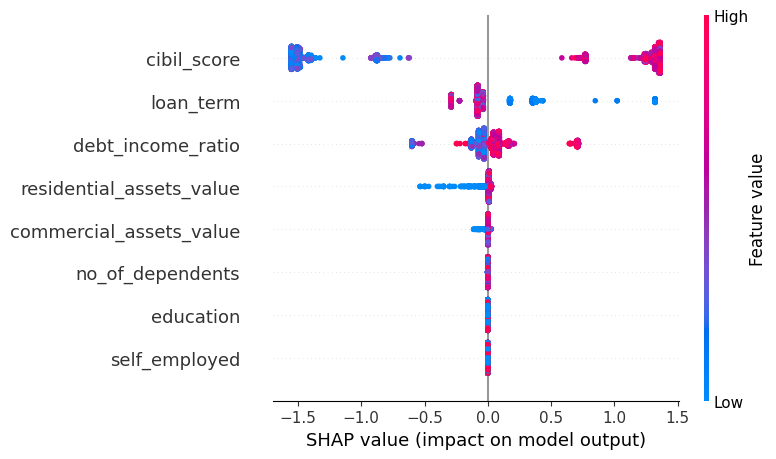

In [35]:
shap.initjs()

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

Main findings



*   Higher cibil score is preferred
*   Shorter loan terms are preferred


Instance based explanability

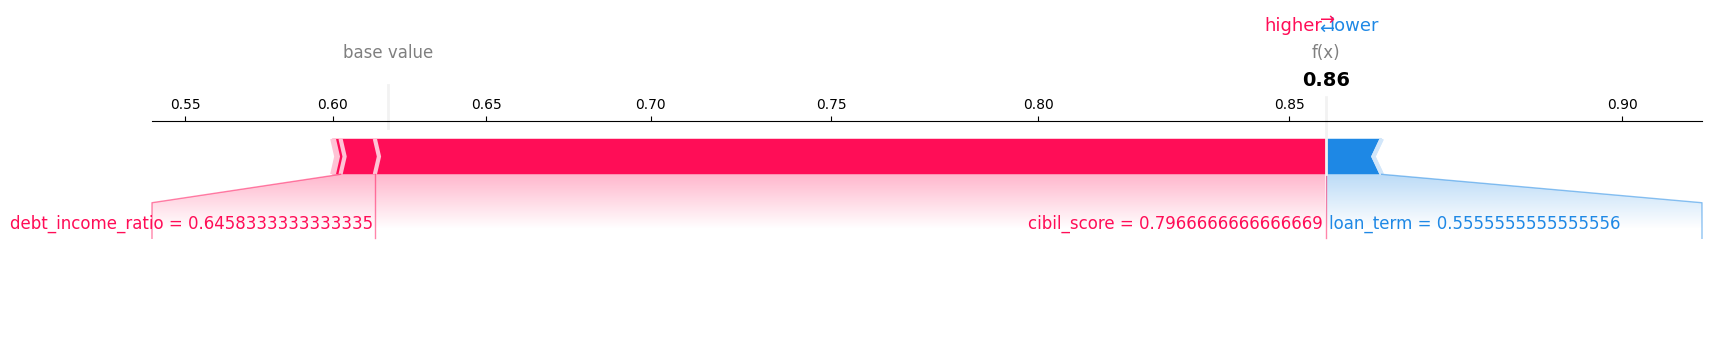

In [36]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :], matplotlib=True,
                link='logit', contribution_threshold=0.5)

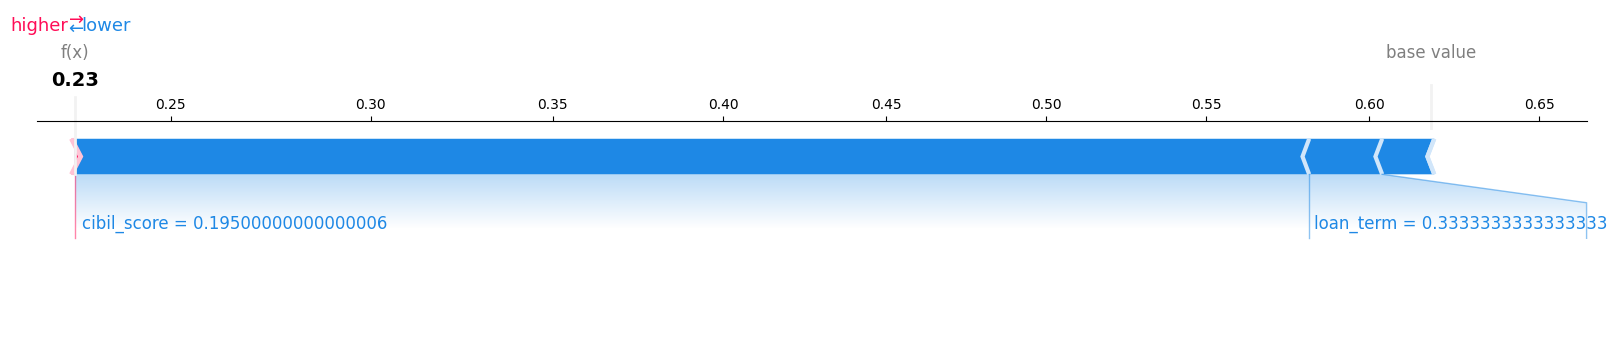

In [37]:
shap.force_plot(explainer.expected_value, shap_values[1, :], X.iloc[1, :], matplotlib=True,
                link='logit', contribution_threshold=0.5)

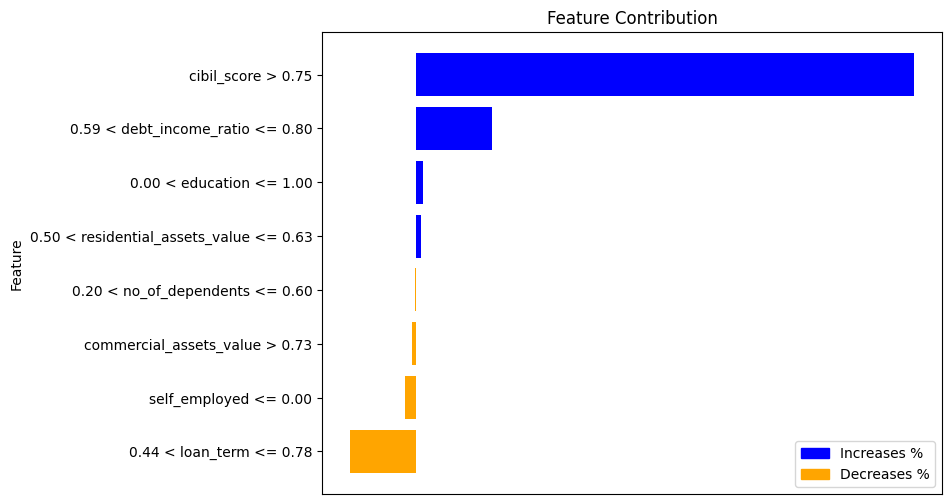

In [38]:
# Initialize the LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['Rejected', 'Good'], discretize_continuous=True)

# Generate explanation
explanation = explainer.explain_instance(X.iloc[0].values, xgb_model.predict_proba)

# Get feature importance and names
feature_importance = explanation.as_list()
features = [x[0] for x in feature_importance]
importance = [x[1] for x in feature_importance]

# Sort features by importance
sorted_indices = np.argsort(importance)[::-1]
features = [features[i] for i in sorted_indices]
importance = [importance[i] for i in sorted_indices]

# Plot bar chart
plt.figure(figsize=(8, 6))
bars = plt.barh(features, importance, color=['blue' if imp >= 0 else 'orange' for imp in importance])
plt.ylabel('Feature')
plt.title('Feature Contribution')
plt.gca().invert_yaxis()  # Invert y axis to have the most important features at the top
plt.xticks([])  # Remove ticks on x axis

# Add legend
legend_labels = ['Increases %', 'Decreases %']
legend_patches = [plt.Rectangle((0,0),1,1, color='blue'), plt.Rectangle((0,0),1,1, color='orange')]
plt.legend(legend_patches, legend_labels)

plt.show()

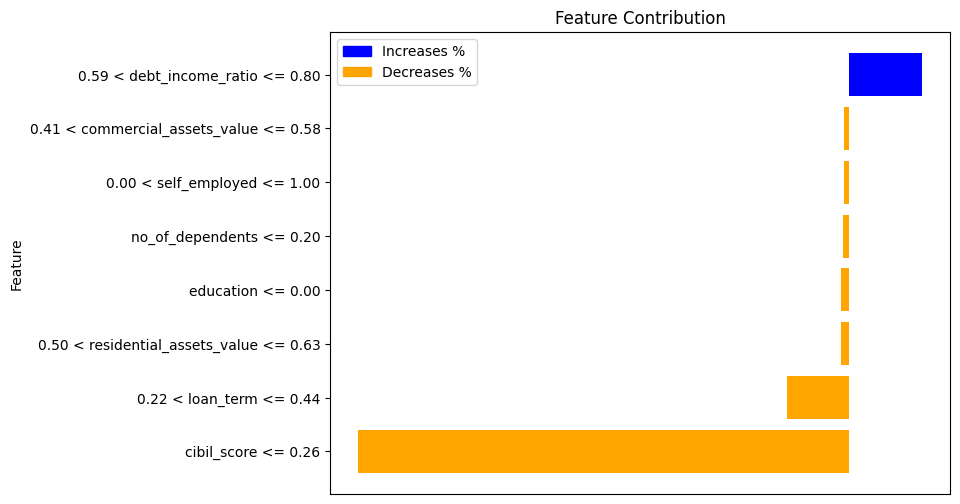

In [39]:
# Initialize the LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['Rejected', 'Good'], discretize_continuous=True)

# Generate explanation
explanation = explainer.explain_instance(X.iloc[1].values, xgb_model.predict_proba)

# Get feature importance and names
feature_importance = explanation.as_list()
features = [x[0] for x in feature_importance]
importance = [x[1] for x in feature_importance]

# Sort features by importance
sorted_indices = np.argsort(importance)[::-1]
features = [features[i] for i in sorted_indices]
importance = [importance[i] for i in sorted_indices]

# Plot bar chart
plt.figure(figsize=(8, 6))
bars = plt.barh(features, importance, color=['blue' if imp >= 0 else 'orange' for imp in importance])
plt.ylabel('Feature')
plt.title('Feature Contribution')
plt.gca().invert_yaxis()  # Invert y axis to have the most important features at the top
plt.xticks([])  # Remove ticks on x axis

# Add legend
legend_labels = ['Increases %', 'Decreases %']
legend_patches = [plt.Rectangle((0,0),1,1, color='blue'), plt.Rectangle((0,0),1,1, color='orange')]
plt.legend(legend_patches, legend_labels)

plt.show()

In [40]:
# Save X_train for LIME explanations
X_train.to_csv('X_train.csv', index=True)